In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install neptune-client

In [1]:
%cd /content/drive/MyDrive/STUDY/Semester\ Four/COMP8420/A2/code
# setup neptune
import neptune.new as neptune
api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMjljZDQxYi1mODc1LTQ4ODktODYxMi0zNDcxZmIxY2E0YTgifQ=='

/content/drive/MyDrive/STUDY/Semester Four/COMP8420/A2/code


In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import pandas as pd
import numpy as np
import read_data
import os
import shutil
from PIL import Image
import MyModels
import dataset
import random
import time
from matplotlib import pyplot as plt

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device('cuda', 0)
else:
    device = torch.device('cpu')
print('use ', device)

# hyper-parameter
batch_size = 16
learning_rate = 1e-6
epoches = 75

seed = 434
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

use  cuda:0


In [4]:
def get_original_dataset(k):
    '''
    split the crop images dataset training/test set
    '''
    training = list(range(5))
    training.remove(k)
    test = [k]

    df = read_data.load_dataframe()
    training_list = df[df['fold'].isin(training)][['image_path', 'class']].to_numpy()
    test_list = df[df['fold'].isin(test)][['image_path', 'class']].to_numpy()

    transform = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])
    
    dataset_train = dataset.OringalSet(training_list, transform)
    dataset_test = dataset.OringalSet(test_list, transform)

    return dataset_train, dataset_test

In [5]:
model = MyModels.AutoEncoder().to(device)
criterion = nn.MSELoss()
# define below in the training section
# criterion = nn.BCELoss(size_average=False)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

dataset_train, dataset_test = get_original_dataset(0)
datasets = {
            'train': dataset_train,
            'val': dataset_test
        }

trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)
dataLoaders = {
    'train': trainloader,
    'val': testloader
}

In [6]:
model

AutoEncoder(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(9, 9), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=9, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=9, stride=1, padding=0, dilation=1, ceil_mode=False)
  (encFC1): Linear(in_features=33856, out_features=4096, bias=True)
  (encFC2): Linear(in_features=33856, out_features=4096, bias=True)
  (decFC1): Linear(in_features=4096, out_features=33856, bias=True)
  (trans_conv1): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(9, 9), stride=(2, 2), output_padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (unpool1): MaxUnpool2d(kernel_size=(9, 9), stride=(1, 1), padding=(0, 0))
  (unpool2): MaxUnpool2d(kernel_size=(9, 9), stride=(1, 1), padding=(0, 0))
  (trans

In [7]:
def train_model(k, model, datasets, dataLoaders, criterion, optimizer, scheduler, num_epoches, save_path):
    for epoch in range(num_epoches):
        if epoch%int(num_epoches/10) == 0:
            print('Epoch {}/{}'.format(epoch, num_epoches-1))
            print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'val']:
            since_epoch = time.time()
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.
            for data in dataLoaders[phase]:
                inputs, _ = data
                inputs = inputs.to(device)
                optimizer.zero_grad()

                # forward
                outputs, mu, logVar = model(inputs)
                kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
                loss = criterion(outputs, inputs) + kl_divergence

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
            
            epoch_loss = running_loss / len(datasets[phase])
            run['Fold {}/{}/{}'.format(k, phase, 'epoch_loss')].log(epoch_loss)

    path = os.path.join(save_path, 'Fold{}_model.pth'.format(k))
    torch.save(model, path)
    return model


In [8]:
# setup neptune
run = neptune.init(project='panxnan/SFEW',
                api_token=api_token)

path = './models/autoencoder'
if not os.path.exists(path):
    os.mkdir(path)
    print('made directorary ', path)
model = train_model(0, model, datasets, dataLoaders, criterion, optimizer, exp_lr_scheduler, epoches, path)

https://app.neptune.ai/panxnan/SFEW/e/SFEW-48
Epoch 0/74
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 7/74
----------
Epoch 14/74
----------
Epoch 21/74
----------
Epoch 28/74
----------
Epoch 35/74
----------
Epoch 42/74
----------
Epoch 49/74
----------
Epoch 56/74
----------
Epoch 63/74
----------
Epoch 70/74
----------


In [ ]:
model = torch.load('models/autoencoder/Fold0_model.pth')

In [ ]:
model

In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
unnorm = UnNormalize(mean, std)

torch.Size([3, 256, 256])
tensor(1.9254)
torch.Size([3, 256, 256])
tensor(0.8745)


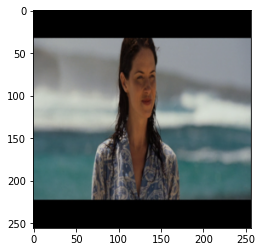

In [10]:
for index, data in enumerate(dataLoaders['val']):
    if index == 4:
        images, _ = data
        break
index = 4
image = images[index]
print(image.shape)
print(torch.max(image))

im = unnorm(image)
print(im.shape)
print(torch.max(im))
im = im.permute(1, 2, 0)
plt.imshow(im)

torch.Size([3, 256, 256])
tensor(0.0722) tensor(0.)
tensor(0.0722) tensor(0.)


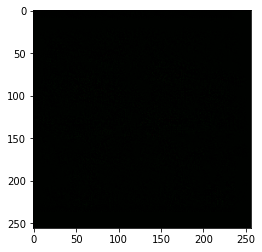

In [12]:
image_new, _, _ = model(images.cuda())
im_new = torch.clone(image_new[index].cpu().detach())
print(im_new.shape)
print(torch.max(im_new), torch.min(im_new))

# im_new = unnorm(im_new)
print(torch.max(im_new), torch.min(im_new))
# print(torch.max(im_new), torch.min(im_new))
# print(im_new.shape)


plt.imshow(im_new.permute(1,2,0))